In [1]:
!ls

LICENSE                           README.md
News_sentiment_Glove+BiLSTM.ipynb dataset
Predict_news_sentiment new.ipynb  submission3.csv
Predict_news_sentiment.ipynb      train_model_dropNaN


In [2]:
%cd drive/My\ Drive/SIC\ -\ BigData/8.\ Project/

[Errno 2] No such file or directory: 'drive/My Drive/SIC - BigData/8. Project/'
/Users/yudhna_/News-Sentiment-Prediction


/Users/yudhna_/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import spacy
#from sklearn.externals import joblib
import joblib
import nltk
# nltk.download('stopwords')
# print('Downloaded Stopwords')
from nltk.corpus import stopwords
import re
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
stop_words = STOP_WORDS
import string
punctuations = string.punctuation
from sklearn.feature_extraction.text import HashingVectorizer

In [134]:
#Import dataset
train = pd.read_csv('dataset/train_file.csv')
test = pd.read_csv('dataset/test_file.csv')

In [135]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [136]:
train.loc[0,'Headline']

'Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor'

In [137]:
train.loc[0,'Title']

'Obama Lays Wreath at Arlington National Cemetery'

In [138]:
test.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
0,tFrqIR6Chj,Sliding Economy: FG fights back with N3trn TSA...,With the 2016 budget now passed by the Nationa...,BusinessDay,economy,2016-03-29 01:41:12,0,0,1
1,DVAaGErjlF,Microsoft shows how HoloLens can bring distant...,A recent Microsoft Research video shows how th...,Daily Mail,microsoft,2016-03-29 01:41:27,121,2,13
2,OT9UIZm5M2,"Microsoft’s Twitter Robot Praises Hitler, Trum...",* Microsoft teamed with Bing to create TayTwee...,EURweb,microsoft,2016-03-29 01:47:00,12,1,0
3,lflGp3q2Fj,Flood of Central Bank Moves Can't Get World Ec...,Central bankers have managed to steer the worl...,Bloomberg via Yahoo! Finance,economy,2016-03-29 02:00:00,0,0,3
4,zDYG0SoovZ,USD/JPY: bears lining up on mixed U.S. economy...,"However, this streak of seven-day gains might ...",FXStreet,economy,2016-03-29 02:01:07,3,0,0


In [139]:
#Đếm NaN Ở Các Cột
missing_val = pd.DataFrame(train.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,0
3,Source,175
4,Topic,0
5,PublishDate,0
6,Facebook,0
7,GooglePlus,0
8,LinkedIn,0
9,SentimentTitle,0


In [140]:
train[train['Source'].isna()]

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
6,lKg2pImhCl,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",NaN,palestine,2016-02-28 14:03:00,0,0,0,0.000000,-0.005906
56,ZOKue2cqfO,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 09:29:00,0,0,0,0.000000,0.048546
111,JXfRvxs0R6,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 00:15:00,0,0,0,-0.243068,0.048546
350,A1YOXDsuOO,Human rights situation in Palestinian territor...,In a special meeting convened by the UN Human ...,NaN,palestine,2015-10-28 17:24:00,-1,-1,-1,-0.228299,-0.124931
409,fO2mYsUg5P,Japan Contributes $5.73M To UNRWA’s Food Assis...,"JERUSALEM, October 31, 2015 (WAFA) – The Japan...",NaN,palestine,2015-10-31 04:30:00,-1,-1,-1,0.166667,-0.042878
...,...,...,...,...,...,...,...,...,...,...,...
55482,FJZonPtvqe,"Monday, 28 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 04:35:00,0,0,0,-0.243068,0.068465
55483,NanKfuNzsO,"Saturday, 16 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 04:36:00,-1,-1,-1,0.000000,0.068465
55486,ovFBb4XFt4,"Sunday, 17 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 05:07:00,-1,-1,-1,0.000000,0.068465
55620,H2PlLqiX9U,"Tuesday, 29 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-28 14:06:00,0,0,0,-0.243068,0.068465


In [141]:
#train.dropna(inplace=True)

In [142]:
test[test['Source'].isna()]

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
78,tgkeH242IX,"Tuesday, 19 Apr 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-29 07:24:00,-1,-1,-1
207,6EnfIIM2XK,"Wednesday, 30 Mar 2016","JERICHO, March 28, 2016 (WAFA) – Secretary Gen...",NaN,palestine,2016-03-29 14:10:00,0,0,0
456,QVFvknH8BH,"Thursday, 21 Apr 2016","RAMALLAH, March 30, 2016 (WAFA) – On the occas...",NaN,palestine,2016-03-30 02:36:00,-1,-1,-1
469,ssRPV1RQKA,"Wednesday, 30 Mar 2016","RAMALLAH, March 30, 2016 (WAFA) – On the occas...",NaN,palestine,2016-03-30 03:37:00,-1,-1,-1
514,jZ35MMRYnw,"Wednesday, 30 Mar 2016","RAMALLAH, March 30, 2016 (WAFA) – On the 40 th...",NaN,palestine,2016-03-30 06:51:00,0,0,0
...,...,...,...,...,...,...,...,...,...
26920,KjltvY9p6K,May Economy Watchers Survey:Expectations index...,The latest announced May Economy Watchers Surv...,NaN,economy,2016-06-08 19:13:00,-1,0,0
26962,ycqBL8nI3c,May Economy Watchers Survey:Current Trends Ind...,The latest announced May Economy Watchers Surv...,NaN,economy,2016-06-08 22:10:00,-1,0,0
29254,o9lTYSMTJe,Microsoft Announces Quarterly Div of US36 Cent...,Microsoft announced that the quarterly dividen...,NaN,microsoft,2016-06-14 22:11:00,-1,0,0
30545,EMy4yLPi0I,U.S. California Surpasses France as World's 6t...,California is now the sixth-largest economy in...,NaN,economy,2016-06-17 21:59:00,0,0,0


In [143]:
#Nếu 'Source==NaN' thì cho nó bằng 'Source' xuất hiện nhiều nhất
most_frequent = test['Source'].mode()[0]
test.fillna({'Source':most_frequent}, inplace=True)
#test[test['PublishDate'] == '2016-03-29 07:24:00'].head()

train = train.drop(columns=['PublishDate','Facebook','LinkedIn','GooglePlus'])
train.head()

test = test.drop(columns=['PublishDate','Facebook','LinkedIn','GooglePlus'])
test.head()

### **EDA - Data Visualization**

In [144]:
sns.set(style='darkgrid',palette='Set1')

In [145]:
!pip install scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/fonttools-4.53.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


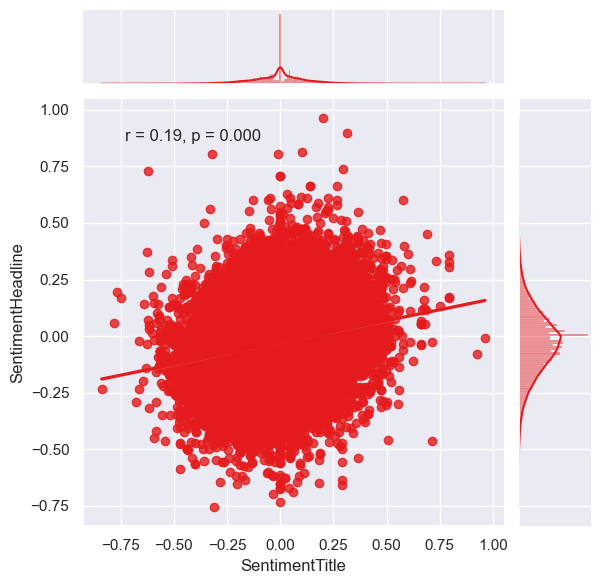

In [146]:
_ = sns.jointplot(x='SentimentTitle',y='SentimentHeadline',data=train,kind = 'reg')

# Calculate Pearson correlation
r, p = stats.pearsonr(train['SentimentTitle'], train['SentimentHeadline'])

# Annotate the plot
plt.annotate(f'r = {r:.2f}, p = {p:.3f}',
             xy=(0.1, 0.9), xycoords='axes fraction')

plt.show()

#_.annotate(stats.pearsonr)
#plt.show()

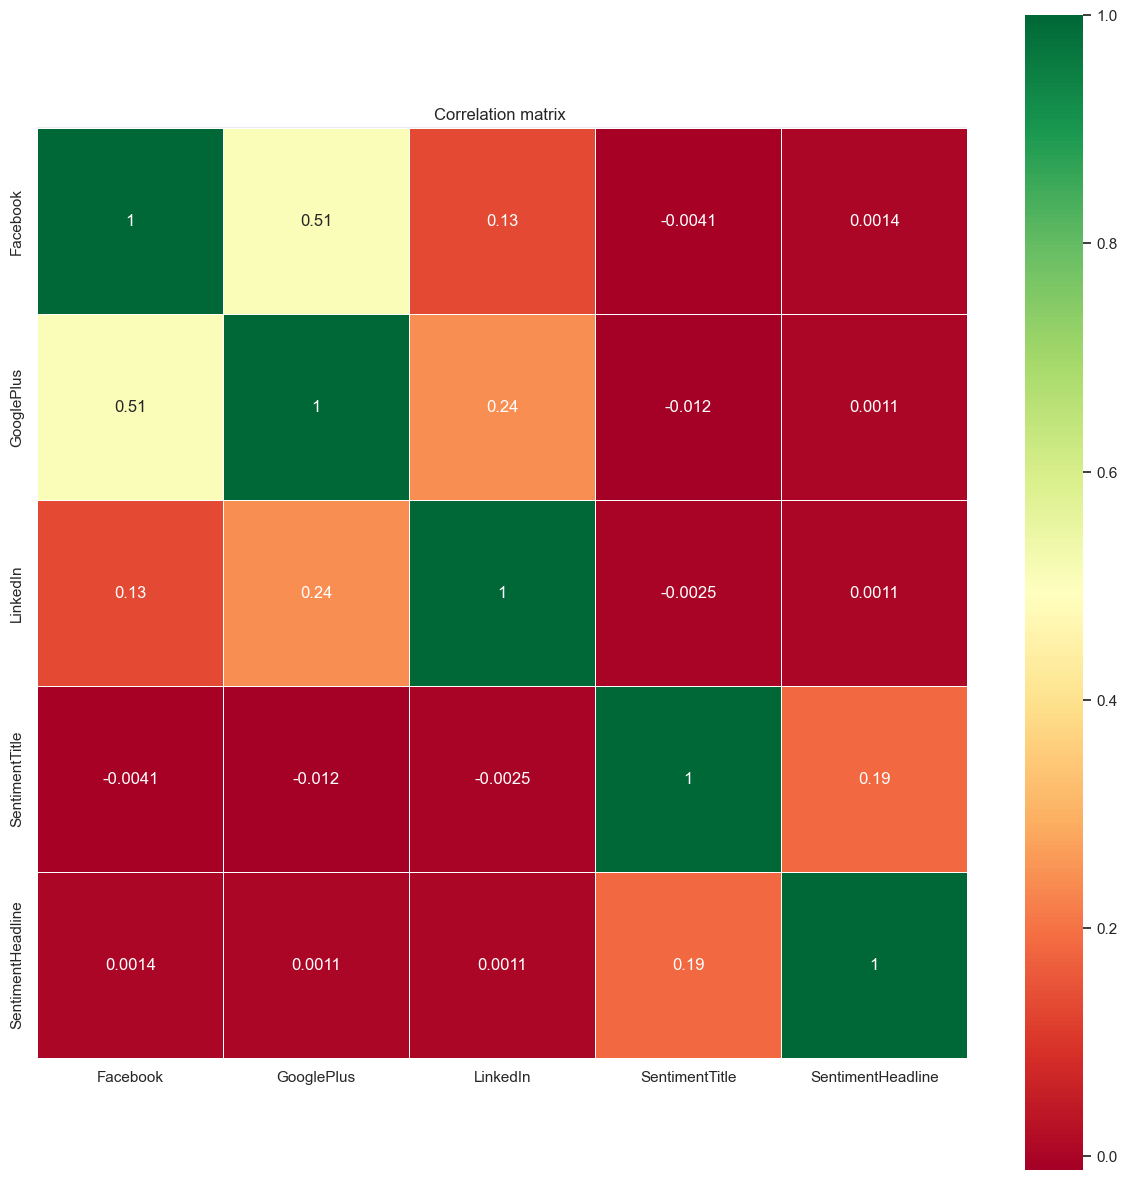

In [148]:
plt.figure(figsize=(15,15))
_ = sns.heatmap(train[['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')

plt.show()

In [149]:
train.columns

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'Facebook', 'GooglePlus', 'LinkedIn', 'SentimentTitle',
       'SentimentHeadline'],
      dtype='object')

In [150]:
train.shape

(55757, 11)

In [151]:
train.index

Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,    10,
       ...
       55922, 55923, 55924, 55925, 55926, 55927, 55928, 55929, 55930, 55931],
      dtype='int64', length=55757)

### Loading spacy English model

In [152]:
nlp = English()

### Custom Tokenizer

#ternimal ==> python -m spacy download en_core_web_sm

In [153]:
# Creating our tokenizer function
#import spacy
#import string

nlp = spacy.load('en_core_web_sm')
#stop_words = spacy.lang.en.stop_words.STOP_WORDS
#punctuations = string.punctuation

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    lemmatized_tokens = []
    for word in mytokens:
        lemma = word.lemma_
        if lemma != "-PRON-":
            lemma = lemma.lower().strip()
        else:
            lemma = word.lower_
        lemmatized_tokens.append(lemma)
    final_tokens = [word for word in lemmatized_tokens if word not in stop_words and word not in punctuations]
    return final_tokens

In [155]:
#Test Tokenizer function
sample_text = "Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor"
tokens = spacy_tokenizer(sample_text)
print(tokens)

['obama', 'lays', 'wreath', 'arlington', 'national', 'cemetery', 'president', 'barack', 'obama', 'lay', 'wreath', 'tomb', 'unknowns', 'honor']


### Custom Transformer and text cleaner

In [156]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
def clean_text(text):
    return text.strip().lower()

In [157]:
bow_vector = CountVectorizer(max_features = 100,tokenizer = spacy_tokenizer,ngram_range=(1,2))

In [158]:
X_train_title = train.loc[:,'Title'].values
y_train_title = train.loc[:,['SentimentTitle']].values

X_train_headline = train.loc[:,'Headline'].values
y_train_headline = train.loc[:,['SentimentHeadline']].values

In [159]:
X_test_title = test.loc[:,'Title'].values
X_test_headline = test.loc[:,'Headline'].values

In [160]:
X_train_title.shape

(55757,)

In [161]:
X_train_headline.shape

(55757,)

In [162]:
y_train_headline.shape

(55757, 1)

In [35]:
from sklearn.model_selection import train_test_split
x_train_title, x_valid_title, Y_train_title, y_valid_title = train_test_split(X_train_title, y_train_title, shuffle = True, test_size = 0.1)
x_train_headline, x_valid_headline, Y_train_headline, y_valid_headline = train_test_split(X_train_headline, y_train_headline, shuffle = True, test_size = 0.1)

In [36]:
abs_y_train_title=np.sign(Y_train_title)
abs_y_train_headline=np.sign(Y_train_headline)
abs_y_valid_title=np.sign(y_valid_title)
abs_y_valid_headline=np.sign(y_valid_headline)

### XGBoost Regressor


In [37]:
xgboost = MultiOutputRegressor(XGBRegressor())
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=None,
                                                          random_state=0))

In [38]:
pipe1 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', regr_multirf)])

pipe2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', regr_multirf)])

#### Title model generation

In [39]:
pipe1.fit(x_train_title,Y_train_title)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x17f0b0f90>),
                ('vectorizer',
                 CountVectorizer(max_features=100, ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x17ee79da0>)),
                ('tfidf', TfidfTransformer()),
                ('regressor',
                 MultiOutputRegressor(estimator=RandomForestRegressor(random_state=0)))])

In [40]:
pipe2.fit(x_train_headline,Y_train_headline)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x17f0b21d0>),
                ('vectorizer',
                 CountVectorizer(max_features=100, ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x17ee79da0>)),
                ('tfidf', TfidfTransformer()),
                ('regressor',
                 MultiOutputRegressor(estimator=RandomForestRegressor(random_state=0)))])

In [41]:
test_pred_title=pipe1.predict(x_valid_title)

In [42]:
test_pred_headline=pipe2.predict(x_valid_headline)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [44]:
mae_title=mean_absolute_error(y_valid_title,test_pred_title)

In [45]:
mae_headline=mean_absolute_error(y_valid_headline,test_pred_headline)

In [46]:
score=1-((0.4*mae_title)+(0.6*mae_headline))

In [47]:
#Score của tập valid
score

0.8984682447058103

In [48]:
pred_title=pipe1.predict(X_test_title)

In [49]:
pred_headline=pipe2.predict(X_test_headline)

In [50]:
submission=pd.DataFrame()

In [51]:
submission['IDLink']=test['IDLink'].to_list()
submission['SentimentTitle']=pred_title
submission['SentimentHeadline']=pred_headline

<h1>View Submisson File</h1>

In [52]:
submission.head()

,IDLink,SentimentTitle,SentimentHeadline
0,tFrqIR6Chj,-0.034952,-0.038591
1,DVAaGErjlF,-0.021623,0.049181
2,OT9UIZm5M2,-0.021623,-0.030068
3,lflGp3q2Fj,-0.003364,-0.011730
4,zDYG0SoovZ,-0.105380,-0.081079


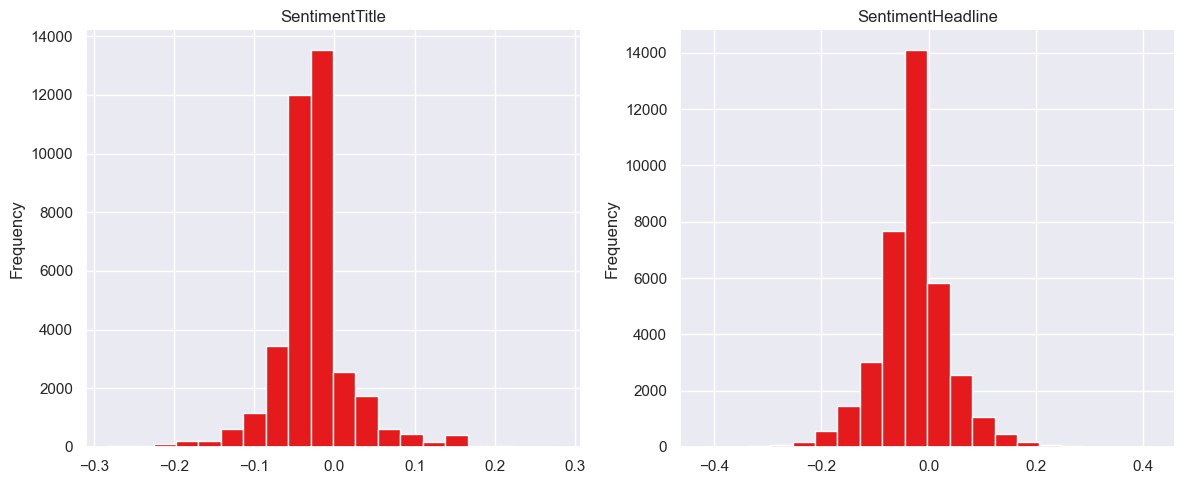

In [53]:
# Tạo một figure với hai trục (axes)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Vẽ biểu đồ phân phối của SentimentTitle trên trục thứ nhất
submission['SentimentTitle'].plot(kind='hist', bins=20, ax=axes[0], title='SentimentTitle')
axes[0].spines[['top', 'right']].set_visible(False)

# Vẽ biểu đồ phân phối của SentimentHeadline trên trục thứ hai
submission['SentimentHeadline'].plot(kind='hist', bins=20, ax=axes[1], title='SentimentHeadline')
axes[1].spines[['top', 'right']].set_visible(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [54]:
submission.to_csv('submission3.csv')

<h1>Play Ground

In [55]:
X_test_tit = np.array(["The US economy is getting better day by day"], dtype=object)
X_test_head = np.array(["The US economy is getting worse day by day"], dtype=object)
pred_title = pipe1.predict(X_test_tit)
pred_headline = pipe2.predict(X_test_head)


In [56]:
print(f"Title prediction: {pred_title[0, 0]}")
print(f"Headline prediction: {pred_headline[0, 0]}")

Title prediction: [[0.08101084]]
Headline prediction: [[-0.08341683]]
